In [1]:
#import keras
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder


from scipy.stats.distributions import gamma
from scipy.stats.distributions import poisson
from scipy.stats.distributions import expon

import statistics
from scipy.stats import norm
from scipy import stats
import scipy.stats

import matplotlib.pyplot as plt

import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions



In [2]:
np.random.seed(7)

In [3]:
#import data
data = pd.read_csv("../PROBABILITY DISTRIBUTION MODELS/H265-data/HarryPotter/harrypotter-QP 10.csv",infer_datetime_format=True,
                  parse_dates=['arrival_time'], index_col='arrival_time', 
                   names=['decoded_frame','arrival_time', 'video_frame', 
                                         'frame_size', 'x', 'y', 'z'])

In [4]:
data.head()

,decoded_frame,video_frame,frame_size,x,y,z
arrival_time,,,,,,
0.00000,0,I,686.0,99.99,99.99,99.99
0.04167,1,B,29.0,99.99,99.99,99.99
0.08333,2,B,30.0,99.99,99.99,99.99
0.12500,3,B,29.0,99.99,99.99,99.99
0.16667,4,B,30.0,99.99,99.99,99.99


In [5]:
data.dropna(0,inplace= True)

In [6]:
print(len(data))

86352


In [7]:
#drop decoded frame column
data.drop(('decoded_frame'), axis=1, inplace=True)

data.drop(('x'), axis=1, inplace=True)
data.drop(('y'), axis=1, inplace=True)
data.drop(('z'), axis=1, inplace=True)

In [8]:
# Label encoding of species column numerically
le = LabelEncoder()
le.fit(data['video_frame'])
print(list(le.classes_))
data['video_frame'] = le.transform(data['video_frame'])

['B', 'I', 'P']


In [9]:
data.head()

,video_frame,frame_size
arrival_time,,
0.00000,1,686.0
0.04167,0,29.0
0.08333,0,30.0
0.12500,0,29.0
0.16667,0,30.0


In [10]:
data.frame_size.dropna(0,inplace= True)

In [11]:
data.reset_index(inplace=True)

In [12]:

data.head()

,arrival_time,video_frame,frame_size
0,0.00000,1,686.0
1,0.04167,0,29.0
2,0.08333,0,30.0
3,0.12500,0,29.0
4,0.16667,0,30.0


In [13]:
data.sort_values('arrival_time', inplace=True)
data.reset_index(drop=True, inplace=True)

In [14]:
data.head()

,arrival_time,video_frame,frame_size
0,0.00000,1,686.0
1,0.04167,0,29.0
2,0.08333,0,30.0
3,0.12500,0,29.0
4,0.16667,0,30.0


In [15]:
data.isnull().sum()

arrival_time    0
video_frame     0
frame_size      0
dtype: int64

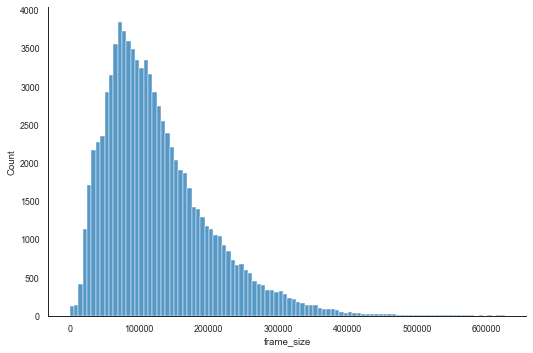

In [16]:
sns.set_style('white')
sns.set_context("paper", font_scale = 1)
sns.displot(data=data, x="frame_size", kind="hist", bins = 100, aspect = 1.5)
plt.show()

In [17]:
data.drop(('arrival_time'), axis=1, inplace=True)
data.drop(('video_frame'), axis=1, inplace=True)

In [18]:
print(data.shape)

(86352, 1)


In [19]:
data.frame_size.values

array([6.86000e+02, 2.90000e+01, 3.00000e+01, ..., 7.94400e+04,
       1.64999e+05, 8.13140e+04])

# Fitting probability distribution models

In [20]:
import matplotlib.pyplot as plt
import scipy
import scipy.stats


dist_names = ['gamma', 'beta', 'rayleigh', 'norm', 'pareto']

for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(data.frame_size)
    # here's the parameters of your distribution, scale, location
    print(param)

(3.0802893031206713, -2573.3329300425394, 41671.65850055881)


c:\users\31950627\keras\lib\site-packages\scipy\stats\_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


(3.0662452741401593, 1628497.376237331, -2487.501099149955, 68161784399.60667)
(3427.2449542294034, 101185.60183964696)
(125787.4293589031, 74195.93864732339)


c:\users\31950627\keras\lib\site-packages\scipy\stats\_distn_infrastructure.py:2494: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


(0.12208222150422862, -0.005608397699763459, 29.005608386662338)


***Fitting distribution models using fitter library***

,sumsquare_error,aic,bic,kl_div
gamma,3.419327e-12,3080.136761,-3.261288e+06,inf
pearson3,3.419327e-12,3080.136809,-3.261288e+06,inf
norm,7.217380e-11,3663.832840,-2.997957e+06,inf
expon,2.766136e-10,2850.674916,-2.881940e+06,inf
lognorm,7.622291e-10,3214.796535,-2.794400e+06,inf


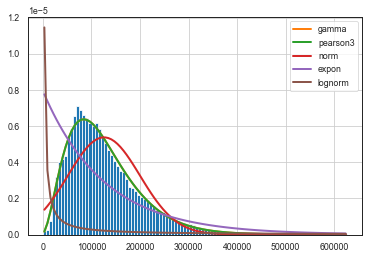

In [21]:
f = Fitter(data.frame_size,
           distributions=['gamma',
                          'lognorm',
                          "expon",
                          "pearson3",
                          "norm"])
f.fit()
f.summary()

In [22]:
#Identifying the best distribution model

f.get_best(method = 'sumsquare_error')


{'gamma': (3.0802893031206713, -2573.3329300425394, 41671.65850055881)}

In [23]:
#Identifying the best parameters

f.fitted_param["pearson3"]

(1.1395521558678974, 125787.42982885928, 73136.89464652564)

# Applying Kolmogorov-Smrinov test

In [24]:
import scipy.stats as st

dist_names = ["norm", "expon", "gamma", "pearson3", "lognorm"]
dist_results = []
params = {}

distname_list = []
chi = []
p_values = []

for dist_name in dist_names:
    
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(data.frame_size)

    params[dist_name] = param
    
    # Applying the Kolmogorov-Smirnov test
    D, p = st.kstest(rvs=data.frame_size.values, cdf=dist_name, args=param, alternative="less", mode="exact")
    print("p value for "+dist_name+" = "+str(p))
    dist_results.append((dist_name, p))
    
    distname_list.append(dist_name)
    chi.append(D)
    p_values.append(p)
    
    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

p value for norm = 0.0
Best fitting distribution: norm
Best p value: 0.0
Parameters for the best fit: (125787.4293589031, 74195.93864732339)
p value for expon = 0.0
Best fitting distribution: norm
Best p value: 0.0
Parameters for the best fit: (125787.4293589031, 74195.93864732339)
p value for gamma = 0.00014480254025039295
Best fitting distribution: gamma
Best p value: 0.00014480254025039295
Parameters for the best fit: (3.0802893031206713, -2573.3329300425394, 41671.65850055881)
p value for pearson3 = 0.0001447987729025836
Best fitting distribution: gamma
Best p value: 0.00014480254025039295
Parameters for the best fit: (3.0802893031206713, -2573.3329300425394, 41671.65850055881)
p value for lognorm = 0.0
Best fitting distribution: gamma
Best p value: 0.00014480254025039295
Parameters for the best fit: (3.0802893031206713, -2573.3329300425394, 41671.65850055881)


In [25]:
result = pd.DataFrame()
result["Distribution"] = distname_list
result["K-Test"] = chi
result["P Values"] = p_values
result = result.sort_values(by="P Values")
result

,Distribution,K-Test,P Values
0,norm,0.068137,0.000000
1,expon,0.209608,0.000000
4,lognorm,0.767525,0.000000
3,pearson3,0.007153,0.000145
2,gamma,0.007153,0.000145


# Data Scaling

In [26]:
values = (1 - 0) * ((data.frame_size - data.frame_size.min()) / (data.frame_size.max() - data.frame_size.min())) + 0
values

0        0.001049
1        0.000000
2        0.000002
3        0.000000
4        0.000002
           ...   
86347    0.130972
86348    0.263085
86349    0.126735
86350    0.263281
86351    0.129725
Name: frame_size, Length: 86352, dtype: float64

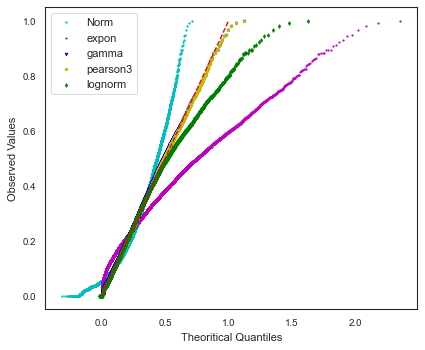

In [27]:
import scipy.stats as st
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

figure(figsize=(6, 5), dpi=80)

dist_names = ["norm", "expon", "gamma", "pearson3", "lognorm"]
dist_results = []
params = {"norm":['+', 'c', 'Norm'],
          "expon":['.', 'm', 'expon'],
          "gamma":['v', 'b', 'gamma'],
          "pearson3":['s', 'y', 'pearson3'],
          "lognorm":['d', 'g', 'lognorm']}

for dist_name in dist_names:
    
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(values)
    TQ, _= st.probplot(x=values, sparams=param, dist=dist_name, fit=True)
    #print(dist_name, TQ)
    #plt.scatter(TQ[0], TQ[1], marker=params[dist_name][0], c=params[dist_name][1],  label=params[dist_name][2])
    
    plt.scatter(TQ[0], TQ[1], marker=params[dist_name][0], c=params[dist_name][1], label=params[dist_name][2], s=5)

plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Theoritical Quantiles", fontsize=10)
plt.ylabel("Observed Values", fontsize=10)
plt.legend(fontsize=10)
plt.show()